In [1]:
from dataloader import LeukemiaLoader
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
print(torch.cuda.is_available())
device=torch.device('cuda',0)
from torch.utils.data import Dataset,DataLoader, SubsetRandomSampler
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
import copy
import csv
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors

True


In [2]:
class Res18_basic_Block(nn.Module):
    def __init__(self, inchannel, outchannel, stride = 1):
        super(Res18_basic_Block, self).__init__()
        
        self.basic = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(outchannel)
        )
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        
        out = self.basic(x)
        out = out + self.shortcut(x)
        out = nn.ReLU()(out)
        
        return out
        

In [3]:
import torch.nn as nn

class Bottleneck(nn.Module):
    
    def __init__(self, inchannel, outchannel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.basic = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=1),  
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),  
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=stride, padding=1),  
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel * self.expansion, kernel_size=1, stride=1),   
            nn.BatchNorm2d(outchannel * self.expansion)
        )
         
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
    
        out = self.basic(x)

        out += identity
        out = nn.ReLU()(out)

        return out


In [4]:
class ResNet_18(nn.Module):
    def __init__(self):
        super(ResNet_18, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)        
        self.layer4 = self.make_layer(512, 2, stride=2)  
        self.classify = nn.Linear(512, 2)
            
       
    def make_layer(self, channel, num_blocks, stride):
        
        strides = [stride] + [1]
        layers = []
        for stride in strides:
            layers.append(Res18_basic_Block(self.inchannel, channel, stride))
            self.inchannel = channel
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = out.view(out.size(0), -1)
        out = self.classify(out)
        return out

In [5]:
class ResNet_50(nn.Module):
    def __init__(self):
        super(ResNet_50, self).__init__()
        self.inchannel = 64
        self.expansion = 4
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.num = [3,4,6,3]
        self.layer1 = self.make_layer(64, self.num[0], stride=1)
        self.layer2 = self.make_layer(128, self.num[1], stride=2)
        self.layer3 = self.make_layer(256, self.num[2], stride=2)        
        self.layer4 = self.make_layer(512, self.num[3], stride=2)  
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classify = nn.Linear(512*4, 2)
            
       
    def make_layer(self,channel, num_blocks, stride):
        
        downsample = None
        if stride != 1 or self.inchannel != channel * self.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inchannel, channel * self.expansion, 1,stride),
                nn.BatchNorm2d(channel * self.expansion)
            )
            
        layers = []
        layers.append(Bottleneck(self.inchannel, channel, downsample=downsample, stride=stride)) 
        self.inchannel = channel*self.expansion   

        for _ in range(1, num_blocks):  
            layers.append(Bottleneck(self.inchannel,channel))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = out.view(out.size(0), -1)
        out = self.classify(out)
        return out

In [6]:
class ResNet_152(nn.Module):
    def __init__(self):
        super(ResNet_152, self).__init__()
        self.inchannel = 64
        self.expansion = 4
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.num = [3,8,36,3]
        self.layer1 = self.make_layer(64, self.num[0], stride=1)
        self.layer2 = self.make_layer(128, self.num[1], stride=2)
        self.layer3 = self.make_layer(256, self.num[2], stride=2)        
        self.layer4 = self.make_layer(512, self.num[3], stride=2)  
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classify = nn.Linear(512*4, 2)
            
       
    def make_layer(self,channel, num_blocks, stride):
        
        downsample = None
        if stride != 1 or self.inchannel != channel * self.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inchannel, channel * self.expansion, 1,stride),
                nn.BatchNorm2d(channel * self.expansion)
            )
            
        layers = []
        layers.append(Bottleneck(self.inchannel, channel, downsample=downsample, stride=stride)) 
        self.inchannel = channel*self.expansion   

        for _ in range(1, num_blocks):  
            layers.append(Bottleneck(self.inchannel,channel))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = out.view(out.size(0), -1)
        out = self.classify(out)
        return out

In [7]:
def evaluate(pred_y, label):
    pred_y = pred_y.to(device)
    label = label.to(device)
    correct = pred_y.max(dim=1)[1].eq(label).sum().item()
    total = label.shape[0]
    accuracy = (correct / total) * 100
    return accuracy

def save_result(csv_path, predict_result):
    df = pd.read_csv(csv_path)
    new_df = pd.DataFrame()
    new_df['ID'] = df['Path']
    new_df["label"] = predict_result
    new_df.to_csv("./your_student_id_resnet18.csv", index=False)
def plot(a,b,c,d,e,f):
    epoch_list = []
    for i in range(len(a)):
        epoch_list.append(i)

    plt.plot(epoch_list, a, label= "res18_train")
    plt.plot(epoch_list, b, label= "res18_test")
    plt.plot(epoch_list, c, label= "res50_train")
    plt.plot(epoch_list, d, label= "res50_test")
    plt.plot(epoch_list, e, label= "res152_train")
    plt.plot(epoch_list, f, label= "res152_test")
    plt.ylim(50, 100)
    plt.legend(loc = 4)
    plt.show()

def plot_confusion_matrix(pred_y, label):


    cm = confusion_matrix(label, pred_y)
    colors = ['white', '#b4c7e7', '#8caad9', '#5a8ed0', '#1974c7']
    cmap = mcolors.ListedColormap(colors)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    classes = [0, 1] 
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()






    

In [8]:
def train(model, loader_train, optimizer, loss_fn):
    model.train()
    total_loss = 0
    total_correct = 0
    counter = 0
    for idx,(data,label, path) in enumerate(loader_train):
        data = data.to(device, dtype=torch.float)
        label = label.to(device, dtype=torch.long)

        optimizer.zero_grad()
        pred_y = model(data)
        mono_loss = loss_fn(pred_y, label)
        mono_loss.backward()
        optimizer.step()

        total_loss += mono_loss
        mono_acc = evaluate(pred_y, label)
        total_correct += mono_acc
        counter+=1

    train_loss = total_loss / len(loader_train.dataset)
    train_accuracy = total_correct / counter
    return train_loss, train_accuracy

def validate(model, loader_test, loss_fn):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    counter = 0
    with torch.no_grad():
        for idx,(data,label, path) in enumerate(loader_test):
            data = data.to(device, dtype=torch.float)
            label = label.to(device, dtype=torch.long)

            pred_y = model(data)
            mono_loss = loss_fn(pred_y, label)

            total_loss += mono_loss
            mono_acc = evaluate(pred_y, label)
            total_correct += mono_acc
            counter+=1

    test_loss = total_loss / len(loader_test.dataset)
    test_accuracy = total_correct / counter
    return test_loss, test_accuracy



In [9]:
def train_and_test(model, loader_train,loader_test): 

    model.to(device)
    lr = 1e-2
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    best_acc = 0
    best_model_wts=None
    total_train = [0]
    total_test = [0]
    epochs = 50
    

    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, loader_train, optimizer, loss_fn)
        total_train.append(train_accuracy)
        test_loss, test_accuracy = validate(model, loader_test, loss_fn)
        total_test.append(test_accuracy)
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        if test_accuracy>best_acc:
            best_evaluated_acc = test_accuracy
            best_model_wts=copy.deepcopy(model.state_dict())
            FILE = 'resnet_50_state_dict.pt'
            torch.save(best_model_wts,FILE)
        scheduler.step()
    
    return total_train, total_test, best_model_wts

In [10]:
def test(model, test_data, weights_path):
    weight_file = weights_path
    model.load_state_dict(torch.load(weight_file))
    model.to(device)
    model.eval()
    result = []


    with open('result.csv', 'w', newline='') as csvfile:
       writer = csv.writer(csvfile)
       writer.writerow(['ID', 'label'])
       with torch.no_grad():
           for idx,(data, path) in enumerate(test_data):
               data = data.to(device, dtype=torch.float)
               pred_y = model(data)
               outputs = pred_y.max(dim=1)[1]
               output = outputs.tolist()
               path = "."+str(path)[2:-3]
               writer.writerow([path, output[0]])
               result += output   
    
    return result
            


In [11]:
def tv_test(model, loader_test, weights_path):
    weight_file = weights_path
    model.load_state_dict(torch.load(weight_file))
    model.to(device)
    model.eval()
    result = []
    labels = []
    acc = 0
    with torch.no_grad():
        for idx,(data, label, path) in tqdm(enumerate(loader_test), total = len(loader_test)):
            data = data.to(device, dtype=torch.float)
            pred_y = model(data)
            outputs = pred_y.max(dim=1)[1]
            output = outputs.tolist()
            result += output  
            label = label.tolist()
            labels += label
            if output == label :
                acc += 1
        acc /= len(loader_test)
    return labels, result, acc
    

            


In [12]:

if __name__ == "__main__":
    batch_size = 64
    
    dataset_train=LeukemiaLoader(root='new_dataset/train/',mode='train')
    loader_train=DataLoader(dataset=dataset_train, batch_size=batch_size,shuffle=False,num_workers=4)
   
    dataset_valid=LeukemiaLoader(root='new_dataset/valid/',mode='valid')
    loader_valid=DataLoader(dataset=dataset_valid,batch_size=batch_size,shuffle=False,num_workers=4)

    

    
    neural_network_18 = ResNet_18()
    res18_train,res18_test, res18_weights= train_and_test(neural_network_18, loader_train,loader_valid)
    print(f"resnet18 max acc：{max(res18_train)}")
    print(f"resnet18_test max acc：{max(res18_test)}")
    FILE = 'resnet_18_all_state_dict.pt'
    torch.save(res18_weights,FILE)
    '''
    a = str(res18_train)
    b = str(res18_test)
    f = open('resnet18_train.txt','w')
    f.write(a)
    f.close()
    f = open('resnet18_test.txt','w')
    f.write(b)
    f.close()
    '''
    '''
    neural_network_50 = ResNet_50()
    res50_train,res50_test, res50_weights= train_and_test(neural_network_50, loader_train,loader_valid)
    print(f"resnet50_train max acc：{max(res50_train)}")
    print(f"resnet50_test max acc：{max(res50_test)}")
    FILE = 'resnet_50_all_state_dict.pt'
    torch.save(res50_weights,FILE)
    a = str(res50_train)
    b = str(res50_test)
    f = open('resnet50_train.txt','w')
    f.write(a)
    f.close()
    f = open('resnet50_test.txt','w')
    f.write(b)
    f.close()
    '''
   
    '''
    neural_network_152 = ResNet_152()
    res152_train,res152_test, res152_weights= train_and_test(neural_network_152, loader_train,loader_valid)
    print(f"resnet152_train max acc：{max(res152_train)}")
    print(f"resnet152_test max acc：{max(res152_test)}")
    FILE = 'resnet_152_all_state_dict.pt'
    torch.save(res152_weights,FILE)
    a = str(res152_train)
    b = str(res152_test)
    f = open('resnet152_train.txt','w')
    f.write(a)
    f.close()
    f = open('resnet152_test.txt','w')
    f.write(b)
    f.close()
    #plot(res18_train,res18_test,res50_train,res50_test, res152_train,res152_test)
    '''
    

> Found 7995 images...
> Found 1599 images...


In [13]:

dataset_test=LeukemiaLoader(root='new_dataset/test/',mode='test18')
loader_test=DataLoader(dataset=dataset_test,batch_size=1,shuffle=False,num_workers=4)

res18 = ResNet_18()
result = test(res18, loader_test, 'resnet_18_all_state_dict.pt')
print(result)




"\ndataset_test=LeukemiaLoader(root='new_dataset/test/',mode='test50')\nloader_test=DataLoader(dataset=dataset_test,batch_size=1,shuffle=False,num_workers=4)\n\nres50 = ResNet_50()\nresult = test(res50, loader_test, 'resnet_50_all_state_dict.pt')\nprint(result)\n\n"

> Found 7995 images...


100%|██████████| 7995/7995 [01:44<00:00, 76.81it/s]


RestNet18 acc:  0.9370856785490932


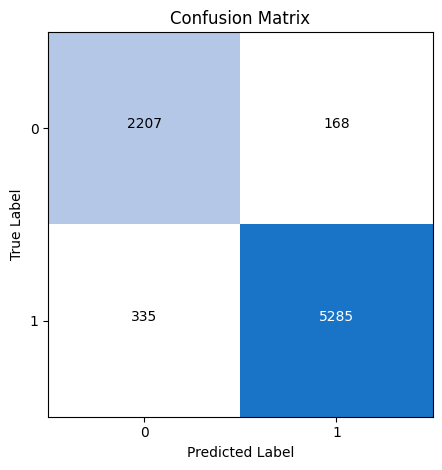

100%|██████████| 7995/7995 [02:58<00:00, 44.87it/s]


RestNet50 acc:  0.915322076297686


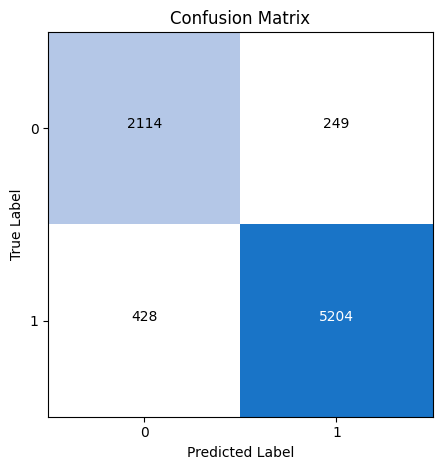

100%|██████████| 7995/7995 [07:22<00:00, 18.07it/s]


RestNet152 acc:  0.915322076297686


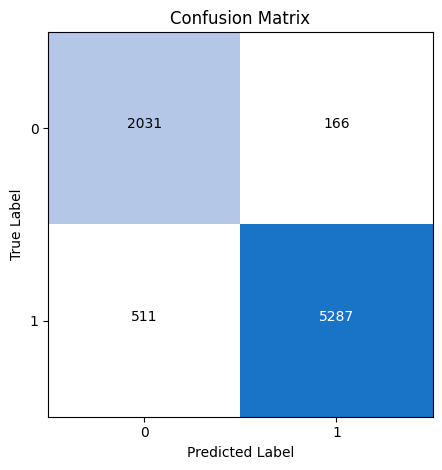

In [14]:
'''
dataset_train=LeukemiaLoader(root='new_dataset/train/',mode='train')
loader_train=DataLoader(dataset=dataset_train, batch_size=1,shuffle=False,num_workers=4)

neural_network_18 = ResNet_18()
labels, result , acc = tv_test(neural_network_18, loader_train, "resnet_18_all_state_dict.pt")
print("RestNet18 acc: ", acc)
plot_confusion_matrix(labels, result)

neural_network_50 = ResNet_50()
labels, result , acc= tv_test(neural_network_50, loader_train, "resnet_50_all_state_dict.pt")
print("RestNet50 acc: ", acc)
plot_confusion_matrix(labels, result)

neural_network_152 = ResNet_152()
labels, result , acc= tv_test(neural_network_152, loader_train, "resnet_152_all_state_dict.pt")
print("RestNet152 acc: ", acc)
plot_confusion_matrix(labels, result)
'''
